## Check directions of the activation patterns

The main thing for this set of experiments is considering how the activation patterns change as we get through the network. In particular, we want to consider how the representation of the points is affected - as we get deep. Indeed, independently from the magnitude of the weights, which is key, but still we do not know how to bound it (for the cross entropy can diverge) the thing we are more interested to is to find the representation that maximizes the output - so to assign the point to the correct class. This leads me to think that we are looking for the representation which maximizes the correlation with the training points for that region. If we want to max correlation, we need two vector to point in the same direction.

Eemergence of directions - maybe more than selectivity (it will be clear next)  
Emergence of compression

In [16]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
# load the original function - teacher network

X_tr, X_vl = np.split(np.load("X_learn.npy"), 2)
y_tr, y_vl = np.split(np.load("y_learn.npy"), 2)
w1, w2 = np.load("true_weights.npy")

In [18]:
n, d = X_tr.shape  # training data dimensions, samples x features
_, k = y_tr.shape  # output dimension, classes
_, h1 = w1.shape   # hidden layer dimension

print(n, d, k, h1)

(100, 30, 5, 3)


**teacher network, $h_1=3$ **  
$$f(x) = (\text{ReLU}(x W_1 ))W_2 ,\ \text{dim}(W_1) = d \times h_1,\text{dim}(W_2) = h_1 \times k $$ 



Two architectures used to model this dataset  
**MODEL1: 1 hidden layer, $h_1 = 30$ ** 
$$f(x) = (\text{ReLU}(x W_1 ))W_2 ,\ \text{dim}(W_1) = d \times h_1,\text{dim}(W_2) = h_1 \times k $$ 
**MODEL2: 2 hidden layers, $h_1 = 30,\ h_2 = 30 $** 
$$f(x) = (\text{ReLU}(\text{ReLU}(x W_1 )W_2))W_3 ,\ \text{dim}(W_1) = d \times h_1,\text{dim}(W_2) = h_1 \times k $$ 

Optimization of square loss, through gradient descent 

For both the models we track several quantities - at every iteration - as weights, activations, activation changes

**initialization weights** - this value is really crucial, small init weights make extremely hard fitting the network. So far I am playing with gd_step 

In [56]:
# load the results

der_act = pickle.load(open("active_change.pkl", "rb"))
weights = pickle.load(open("track_weights.pkl", "rb"))
train_c = pickle.load(open("training_curve.pkl", "rb"))
valid_c = pickle.load(open("validation_curve.pkl" ,"rb"))
init_w1 = pickle.load(open("init_weights_depth_1.pkl", "rb"))
init_w2 = pickle.load(open("init_weights_depth_2.pkl", "rb"))
activat = pickle.load(open("activation.pkl", "rb"))
direct = pickle.load(open("directions.pkl"))

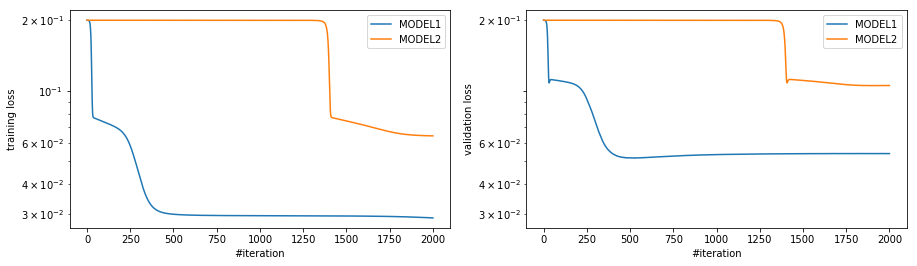

In [60]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
ax[0].semilogy(train_c[0], label="MODEL1")
ax[0].semilogy(train_c[1], label="MODEL2")
ax[0].set_xlabel("#iteration")
ax[0].set_ylabel("training loss")
ax[0].legend();
ax[1].semilogy(valid_c[0], label="MODEL1")
ax[1].semilogy(valid_c[1], label="MODEL2")
ax[1].set_xlabel("#iteration")
ax[1].set_ylabel("validation loss")
ax[1].legend();

** curve of training and validation **  
On the left, loss over training, on the right the validation curve. It is extremely hard to fit MODEL2, when initialized with small weights

In [87]:
classes = 5
possible_labels = np.identity(classes)
set_idx_per_class = [np.where([np.array_equal(row, possible_labels[c]) for row in y_tr])[0] 
                         for c in range(classes)]

def print_activation_curve(activation,  set_idx_per_class, id_h, iterations=2000):
    """
    Given the list of activations, binary quantity, we plot the curves of activations 
    as we train the network.
    Parameters:
        activation, list containing the activations (binary quantity) at each iteration
        set_idx_per_class, index denoting to what class a sample belongs to
        id_h, denotes the architecture for which we want to plot the curves of the last hidden layer
        iterations, number of iterations
    Returns:
        None - plots
    """
    samples, neurons = activation[0][0][0].shape
    np_var_act = np.zeros((neurons, classes, iterations))
    for n in range(neurons):
        for i in range(iterations):
            np_var_act[n, :, i] = np.array([float(np.sum(activation[id_h][id_h][i][s, n]))/len(s) 
                                            for s in set_idx_per_class])  # normalized activation vector 

    fig, ax = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(20, 16))
    for n in range(neurons):
        idx, idy = n / 6, n % 6
        for c in range(classes):
            ax[idx, idy].plot(2 * np.arange(iterations), np_var_act[n, c, :], label="c"+(str(c+1)))
        ax[idx, idy].set_ylim([-0.1, 1.1])
        ax[idx, idy].legend()
        ax[-1, idy].set_xlabel("iterations")
        ax[idx, 0].set_ylabel("# activating samples")

#### Activation curves for MODEL1
as in the previous experiments, we check how the activation patterns change for each class 
here each plot represents the normalized activation relative to each class at each iteration
$$\frac{\text{#activating samples(class=c)}}{ \text{#samples(class=c)}} $$

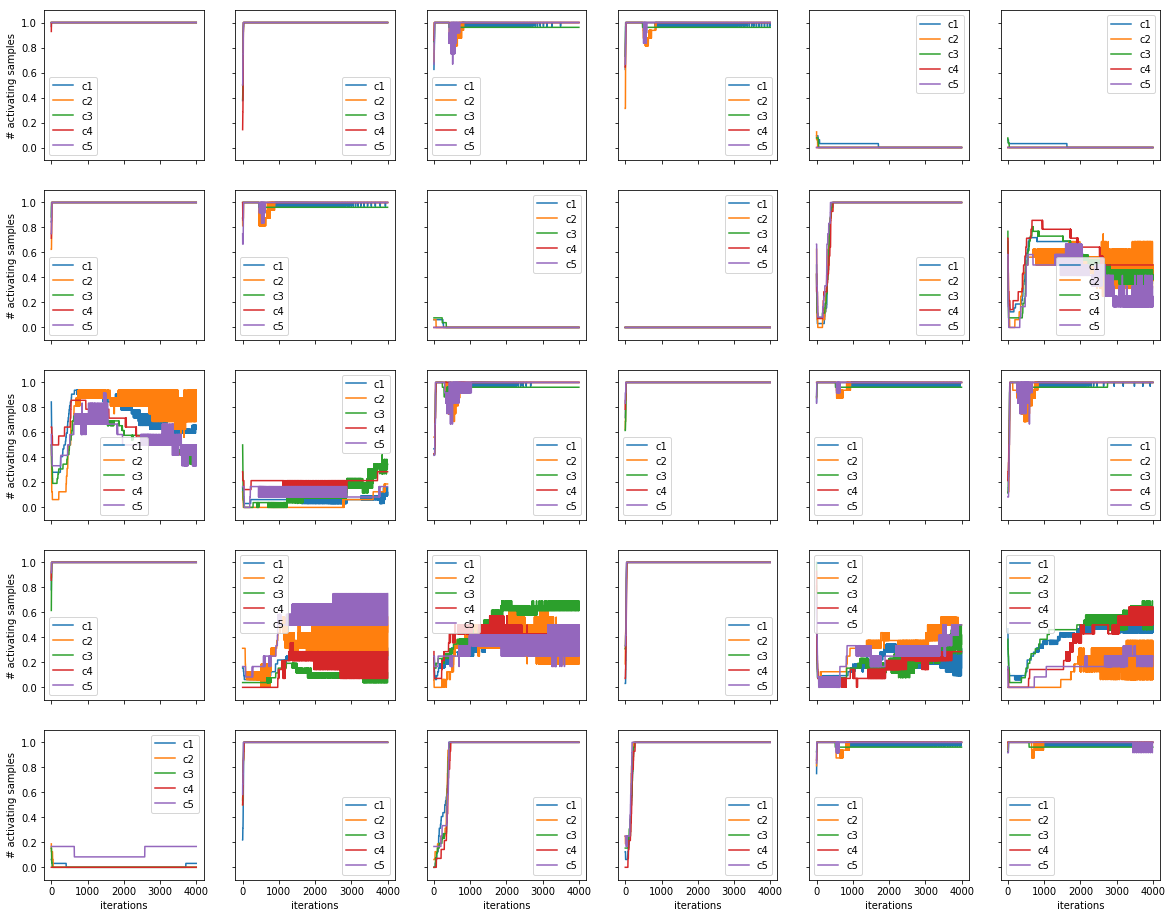

In [165]:
print_activation_curve(activat, set_idx_per_class, id_h=0)  

#### Activation curves for MODEL2, second hidden layer

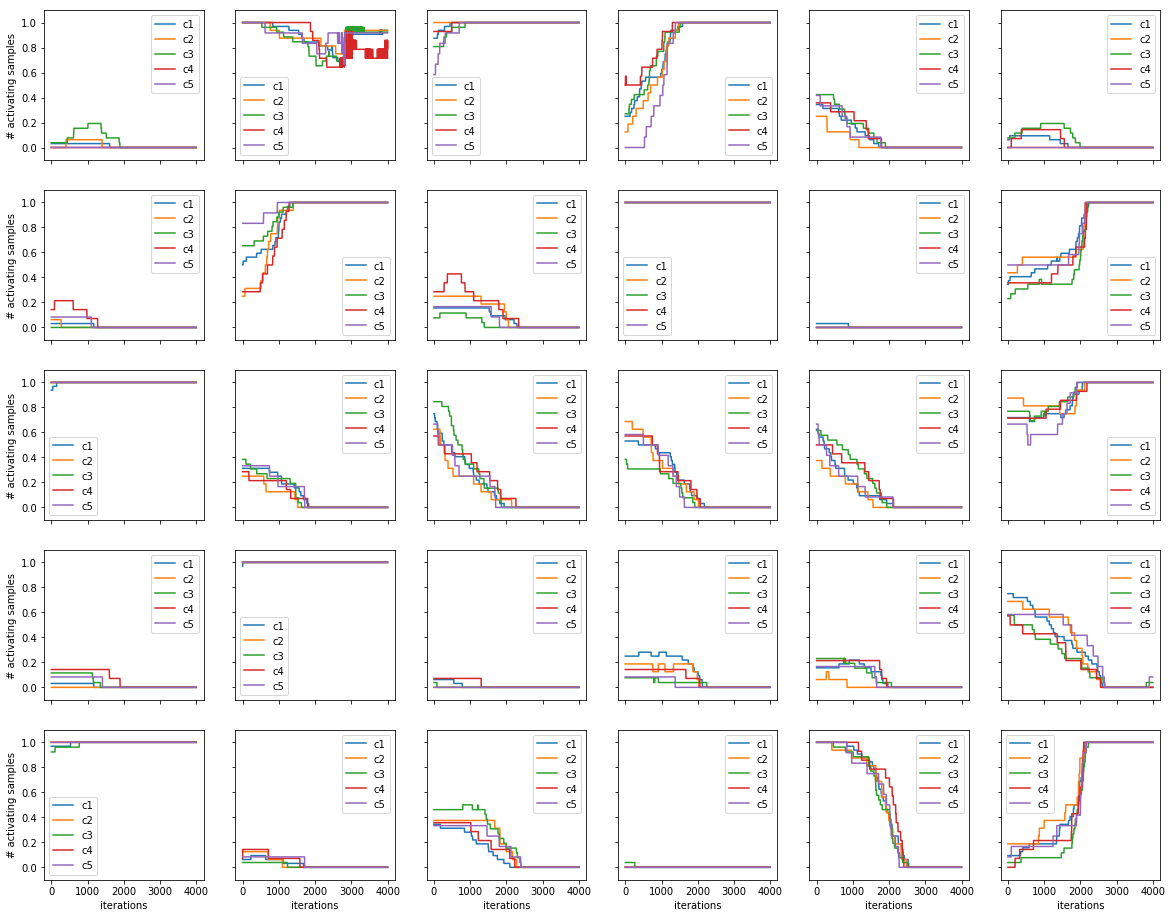

In [62]:
print_activation_curve(activat, set_idx_per_class, id_h=1)

In [92]:
def measure_dist(activation_pattern):
    """
    Given the activation pattern we build a matrix of distances
    based of Frobenius norm between activations.
    Parameters:
        activation_pattern, pattern of activation, matrix of activations
    Returns:
        distances, square matrix which containes the distance values
    """
    n_samples, h_dim = activation_pattern.shape
    distances = np.zeros((n_samples, n_samples))
    for n1 in range(n_samples):
        for n2 in range(n1 + 1, n_samples):
            distances[n1, n2] = np.linalg.norm(activation_pattern[n1] - activation_pattern[n2])
    distances += distances.T
    return distances

In [163]:
def distance_angle(v1, v2):
    """
    Compute the angular distance between two vectors, as
    cos^(-1)(v1, v2) / (||v1|| * ||v2||)
    Parameters:
        v1, array
        v2, array
    Returns:
        angle
    """
    return np.arccos(v1.dot(v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)))

def measure_angular_dist(activation_pattern):
    """
    Given the pattern of activation (real values) for a hidden layer 
    we compute here the angular distance of the activations
    The intuition is that, independently from the norm of the transformation W, 
    the directions we get for the activation patterns of point of the same class
    becomes much similar, if compared to ones of a different class
    """
    n_samples, h_dim = activation_pattern.shape
    ang_distances = np.zeros((n_samples, n_samples))
    for n1 in range(n_samples):
        if np.linalg.norm(activation_pattern[n1]) <1e-5:
            ang_distances[n1] = np.zeros(n_samples)
            n1 += 1
        for n2 in range(n1 + 1, n_samples):
            if np.linalg.norm(activation_pattern[n2]) <1e-5:
                ang_distances[n1, n2] = 0  
            else:
                ang_distances[n1, n2] = distance_angle(activation_pattern[n1], activation_pattern[n2])
    ang_distances += ang_distances.T
    return ang_distances

In [160]:
def check_distances(h_layers_=4, max_val=None):
    
    hidden_nodes = 30
    selectivity = []  # here we save the selectivity index across layers

    matrix_weights_act = np.maximum(0, X_tr.dot(weights[h_layers_-1][0][-1]))  # first ReLU activation

    fig, ax = plt.subplots(h_layers_ * 2, 6, figsize=(15, 12))
        
    for h in range(1, h_layers_+1):
        dist = measure_dist(matrix_weights_act)
        ang_dist = measure_angular_dist(matrix_weights_act)
        
        if h == 1:
            max_val = np.max(dist)
            max_val_ang = np.max(ang_dist)
            print("max distance", max_val)
            print("max ang distance", max_val_ang)
            
        for c_ in range(classes):
            mesh_x, mesh_y = np.meshgrid(set_idx_per_class[c_], set_idx_per_class[c_])
            
            ax[2*(h-1), c_].set_title("class "+ str(c_+1))
            ax[2*(h-1), c_].imshow(dist[mesh_x, mesh_y], vmin=0, vmax=max_val)
            ax[2*(h-1), -1].imshow(dist, vmin=0, vmax=max_val)
            ax[2*(h-1), -1].set_title("all classes - FROBENIUS")
            
            ax[2*(h-1)+1, c_].set_title("class "+ str(c_+1))
            ax[2*(h-1)+1, c_].imshow(ang_dist[mesh_x, mesh_y], vmin=0, vmax=max_val_ang)
            ax[2*(h-1)+1, -1].imshow(ang_dist, vmin=0, vmax=max_val_ang)
            ax[2*(h-1)+1, -1].set_title("all classes - ANGLE")
        
        if h == h_layers_ :
            break 

        matrix_weights_act = np.maximum(0, matrix_weights_act.dot(weights[h_layers_-1][h][-1])) 
    plt.savefig("h_layers_"+str(h_layers_)+".pdf")
    plt.show()

#### Plot of distances 
Here we want to see how the distance changes as the data points goes through the layers. In particular, the intuition is that, independently from the magnitude of the weights, for which we cannot say much, the directions of the patterns of activation can play an important role. In the following plots we alternate the Frobenius norm of the distances of activation patterns with the angular distance for the same activation patterns.

#### MODEL1

1st row: Frobenius distance 1st hidden layer  
2nd row: Angular distance 1st hidden layer

('max distance', 2.51935318066751)
('max ang distance', 1.5707963267948966)


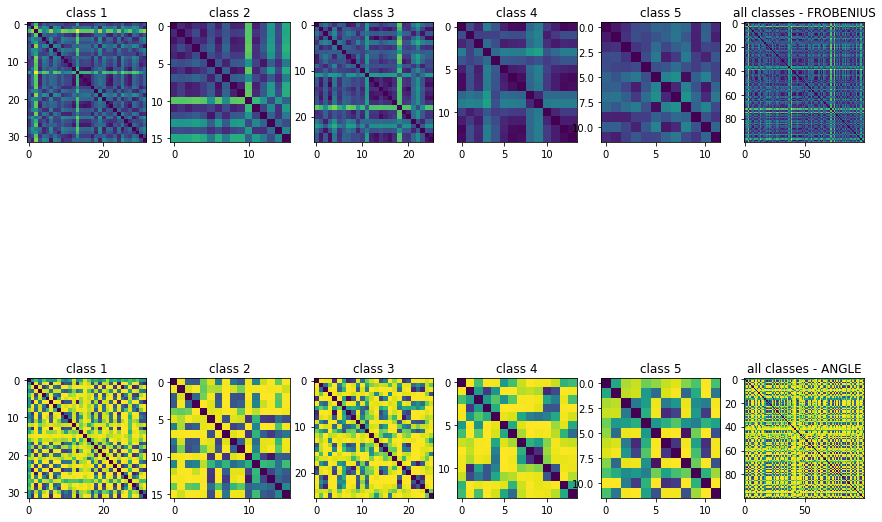

In [161]:
check_distances(1)

#### MODEL2

1st row: Frobenius distance 1st hidden layer  
2nd row: Angular distance 1st hidden layer  
3rd row: Frobenius distance 1st hidden layer  
4th row: Frobenius distance 1st hidden layer

('max distance', 1.6570892680961233)
('max ang distance', 1.5707963267948966)


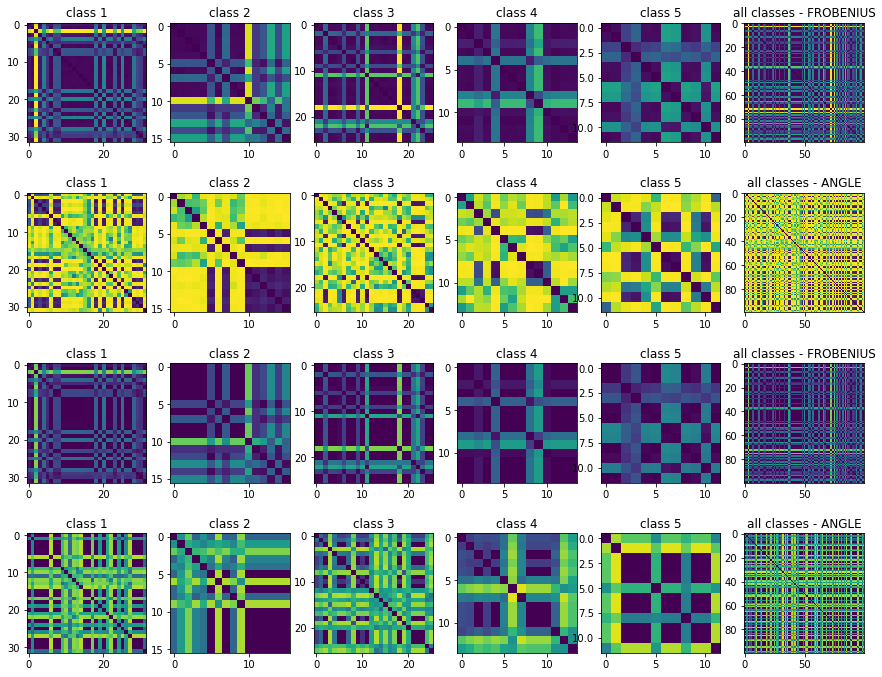

In [164]:
check_distances(2)

### An idea

The idea could be the following. We start by considering two points $x$ and $x'$ in the input space. Let's consider what happens as they pass through the layers. Suppose that these two points fall in the same region at every layer. This means that they are transformed in the same way. Suppose that they activate $K$ regions in the first layer, let's call this smaller transformation $\tilde{W}_1$. Then
$$\| \tilde{W}_1 x - \tilde{W}_1 x' \| ? \| x - x' \| $$
what is the relation between the two quantities. Maybe we cannot say that much on the amplitude, if we do not know how to bound the representation for $\tilde{W}_1$ but still we can say something on the directions. In particular
$$\tilde{W}_1^t=  \tilde{W}_1^0 + \eta \sum_{\tau=1}^t A^\tau \text{subset}^\tau (X)^T$$
The first simple consideration is that every components which is orthogonal to the subset $\text{subset}^\tau (X)$ of training points, is killed by the projection onto them. We are getting rid of orthogonal components, preserving the ones that are related to the training points which activated the region. So if we could have written
\begin{align*} 
x = x_{Pr_{X_{tr}}} + x_\perp \\
x' = x'_{Pr_{X_{tr}}} + x'_\perp \\
\end{align*}
We end up with this representation in the first hidden layer
$\tilde{W}_1 x_{Pr_{X_{tr}}},\  \tilde{W}_1 x'_{Pr_{X_{tr}}}$, where $Pr$ depends on subsets. This allows us to say that, with respect to the first transformation we have obtained a new representation that has lower dimension (if $h_1 < d$). Let's push this further by considering what happens for the second hidden layer. In this case we have
$$\tilde{W}_2^t=  \tilde{W}_2^0 + \eta \sum_{\tau=1}^t B^\tau (\text{subset}^\tau (X) W_1^\tau)^T$$
So the representation at the second hidden layer becomes
\begin{align*} 
\tilde{W}_1 x_{Pr_{X_{tr}}} = (\tilde{W}_1 x_{Pr_{X_{tr}}})_{Pr} + (\tilde{W}_1 x_{Pr_{X_{tr}}})_\perp \\
\tilde{W}_1 x'_{Pr_{X_{tr}}} = (\tilde{W}_1 x'_{Pr_{X_{tr}}})_{Pr} + (\tilde{W}_1 x'_{Pr_{X_{tr}}})_\perp \\
\end{align*}
Here $Pr$ and $\perp$ denote respectively the projection and the orthogonal components with respect to the space 
$$\sum_{\tau=1}^t \tilde{W}^\tau_1 \text{subset}^\tau(X_{tr})$$

By considering the transformation we get at every layer we are performing a kernel distance between the new representations for our point. It could be interesting to start with two points (I want to generate them such that they belong to the same activation regions) and then see what happens as they get through the layers.

I need to write everything in a better form, but the intuition is that, as we get futher in the network, we are projecting more and more on the hidden representation for the training data, getting rid everytime of components which are orthogonal. It seems that we get representations which are more and more similar to the training points. The training points themselves are getting much closer. 

I still don't know if we can say that much on selectivity, from these experiments (very small init values) there is no emergence of selective neurons. 
